## Cluster Analytics


### Import Libraries

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, cos, pi
from datetime import datetime

### Load datasets 

In [40]:
# Load datasets
charging_sessions_data = pd.read_csv("cleaned_data.csv")
weather_data = pd.read_csv("weather_burbank_airport.csv")

In [41]:
# Convert datetime columns
charging_sessions_data["connectionTime"] = pd.to_datetime(charging_sessions_data["connectionTime"], errors='coerce', utc=True)
charging_sessions_data["disconnectTime"] = pd.to_datetime(charging_sessions_data["disconnectTime"], errors='coerce', utc=True)
charging_sessions_data["doneChargingTime"] = pd.to_datetime(charging_sessions_data["doneChargingTime"], errors='coerce', utc=True)
weather_data["timestamp"] = pd.to_datetime(weather_data["timestamp"], errors='coerce', utc=True)

# Convert to Pacific Time
charging_sessions_data["connectionTime"] = charging_sessions_data["connectionTime"].dt.tz_convert('America/Los_Angeles')
charging_sessions_data["disconnectTime"] = charging_sessions_data["disconnectTime"].dt.tz_convert('America/Los_Angeles')
charging_sessions_data["doneChargingTime"] = charging_sessions_data["doneChargingTime"].dt.tz_convert('America/Los_Angeles')
weather_data["timestamp"] = weather_data["timestamp"].dt.tz_convert('America/Los_Angeles')

# Extract date for merging
charging_sessions_data["date"] = charging_sessions_data["connectionTime"].dt.date
weather_data["date"] = weather_data["timestamp"].dt.date

# Merge weather data
charging_sessions_data = charging_sessions_data.merge(
    weather_data[["date", "temperature", "precipitation"]],
    on="date",
    how="left"
)

# Calculate session metrics
charging_sessions_data["session_duration"] = (charging_sessions_data["disconnectTime"] - charging_sessions_data["connectionTime"]).dt.total_seconds() / 3600
charging_sessions_data["idle_time"] = (charging_sessions_data["disconnectTime"] - charging_sessions_data["doneChargingTime"]).dt.total_seconds() / 3600

# Fix division by zero issue
charging_sessions_data["energy_ratio"] = charging_sessions_data["kWhDelivered"] / charging_sessions_data["kWhRequested"].replace(0, np.nan)

# Add time-based features
charging_sessions_data["hour"] = charging_sessions_data["connectionTime"].dt.hour
charging_sessions_data["hour_sin"] = charging_sessions_data["hour"].apply(lambda x: sin(2 * pi * x / 24))
charging_sessions_data["hour_cos"] = charging_sessions_data["hour"].apply(lambda x: cos(2 * pi * x / 24))
charging_sessions_data["weekday"] = charging_sessions_data["connectionTime"].dt.weekday

### Feature Selection and Data Scaling

In [42]:
# Feature Selection
features = charging_sessions_data[
    ["session_duration", "idle_time", "energy_ratio", "hour_sin", "hour_cos", "kWhDelivered", "temperature", "precipitation"]
]

# Check for NaN or Inf values
print("NaN values before processing:")
print(features.isna().sum())

print("Inf values before processing:")
print(np.isinf(features).sum())

# Replace Inf values with NaN and fill missing values with the median
features = features.replace([np.inf, -np.inf], np.nan)
features = features.fillna(features.median())

# Ensure only numeric columns are used
features = features.select_dtypes(include=[np.number])

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

NaN values before processing:
session_duration         0
idle_time                0
energy_ratio        298219
hour_sin                 0
hour_cos                 0
kWhDelivered             0
temperature            497
precipitation            0
dtype: int64
Inf values before processing:
session_duration    0
idle_time           0
energy_ratio        0
hour_sin            0
hour_cos            0
kWhDelivered        0
temperature         0
precipitation       0
dtype: int64


### Elbow Method

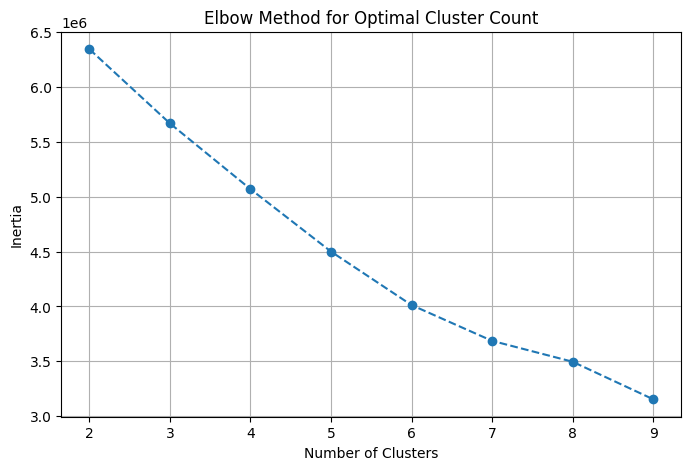

In [43]:
# Elbow Method for optimal clusters
inertia = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o", linestyle="--")
plt.title("Elbow Method for Optimal Cluster Count")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()


The chart represents the Elbow Method for determining the optimal number of clusters. The line, which plots inertia (the sum of squared distances within clusters) against the cluster count, drops sharply and then clearly levels off around 5 to 6 clusters. This distinct “elbow” point indicates that 5 or 6 clusters likely strike the best balance between capturing meaningful structure in the data and avoiding unnecessary complexity

### PCA for visualization

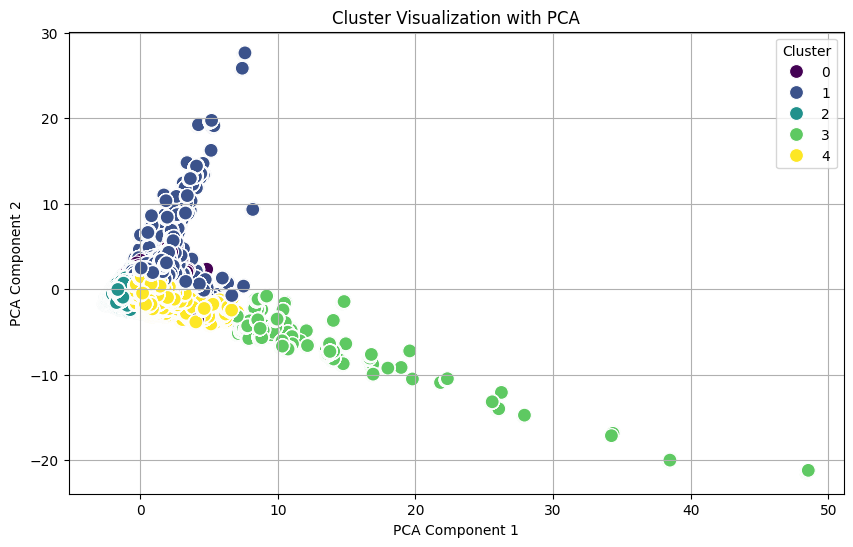

In [44]:
# Clustering with optimal number of clusters (e.g., 5)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
charging_sessions_data["cluster"] = kmeans.fit_predict(scaled_features)

# PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Scatterplot for PCA visualization of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=charging_sessions_data["cluster"],
    palette="viridis",
    s=100
)
plt.title("Cluster Visualization with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc="upper right")
plt.grid()
plt.show()

This scatter plot provides a two-dimensional visualization of the data after applying Principal Component Analysis (PCA). Each color represents a distinct cluster (labeled 0 through 4), and we can see clear groupings in the PCA-transformed space. The fact that these clusters appear relatively well-separated suggests that the chosen clustering approach has effectively captured meaningful differences within the dataset.

### Cluster Summarization

In [45]:
# Cluster Summarization
cluster_summary = charging_sessions_data.groupby("cluster").agg(
    avg_session_duration=("session_duration", "mean"),
    avg_idle_time=("idle_time", "mean"),
    avg_energy_ratio=("energy_ratio", "mean"),
    avg_kWhDelivered=("kWhDelivered", "mean"),
    avg_temperature=("temperature", "mean"),
    avg_precipitation=("precipitation", "mean"),
    session_count=("cluster", "size")
)

# Display cluster summary
print("Cluster Summary:")
print(cluster_summary)


Cluster Summary:
         avg_session_duration  avg_idle_time  avg_energy_ratio  \
cluster                                                          
0                    6.887369       3.269407          0.611213   
1                    9.269607       2.147896          0.897115   
2                    2.973251       0.891469          0.522299   
3                   63.641494      52.859841          0.679623   
4                    8.550744       4.584963          0.596806   

         avg_kWhDelivered  avg_temperature  avg_precipitation  session_count  
cluster                                                                       
0               12.052623        11.253598           4.717863           6739  
1               33.976853        16.455696           0.033474          96473  
2                7.393861        18.597639           0.021765         345965  
3               12.608060        19.280732           0.021582           2295  
4                9.339670        17.959520    

C:\Users\sk212\AppData\Local\Temp\ipykernel_16660\2081490923.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


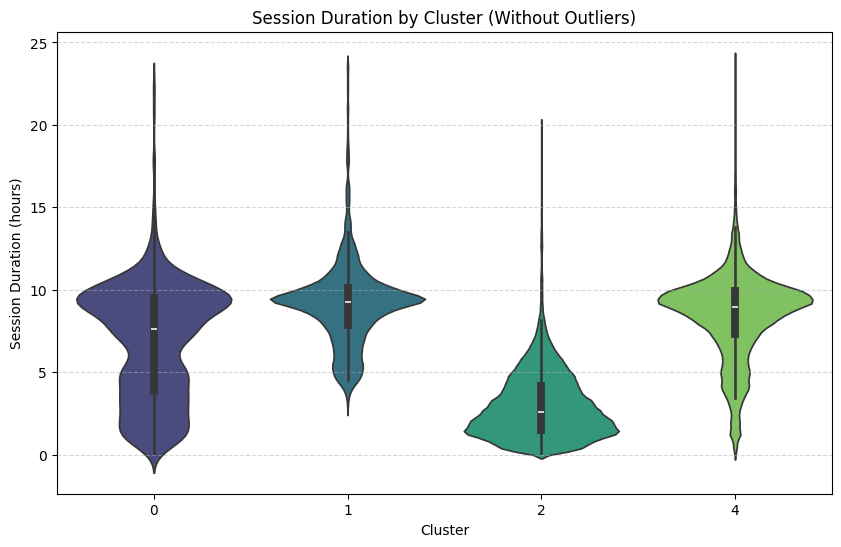

In [46]:
# Filter out outliers (optional, adjust threshold as needed)
threshold = 24
filtered_data = charging_sessions_data[charging_sessions_data["session_duration"] <= threshold]

# Create a violin plot without logarithmic scale
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="cluster",
    y="session_duration",
    data=filtered_data,
    inner="box",
    palette="viridis"
)
plt.title("Session Duration by Cluster (Without Outliers)")
plt.xlabel("Cluster")
plt.ylabel("Session Duration (hours)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

These violin plots illustrate the distribution of session durations (in hours) for each cluster, with obvious outliers removed. We can see that Cluster 0 tends to have shorter sessions, whereas Cluster 2 shows a wider range and a higher median. The box shapes inside each “violin” represent the standard boxplot statistics (median and interquartile range), while the outer shape reflects the distribution of the data. Overall, the plots make it clear that the clusters differ significantly in both their average and maximum session durations.

### Heatmap for temporal and spatial trends

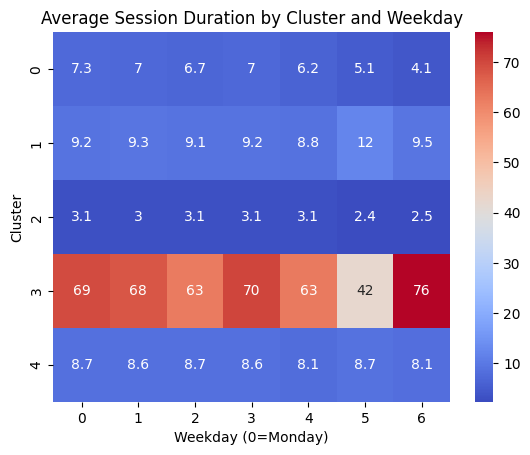

In [47]:
# Heatmap for temporal and spatial trends
time_series = charging_sessions_data.groupby(["cluster", "weekday"])["session_duration"].mean().unstack()
sns.heatmap(time_series, cmap="coolwarm", annot=True)
plt.title("Average Session Duration by Cluster and Weekday")
plt.xlabel("Weekday (0=Monday)")
plt.ylabel("Cluster")
plt.show()


This heatmap illustrates the average session duration (in hours) by weekday (0=Monday) and cluster, with blue indicating shorter and red indicating longer durations. Cluster 1 has notably long sessions on weekends, while Cluster 3 consistently shows the lowest values. The spike in Cluster 4 on Saturday suggests a distinct usage pattern, possibly influenced by demand fluctuations or specific charging station characteristics.

### Time series analysis 

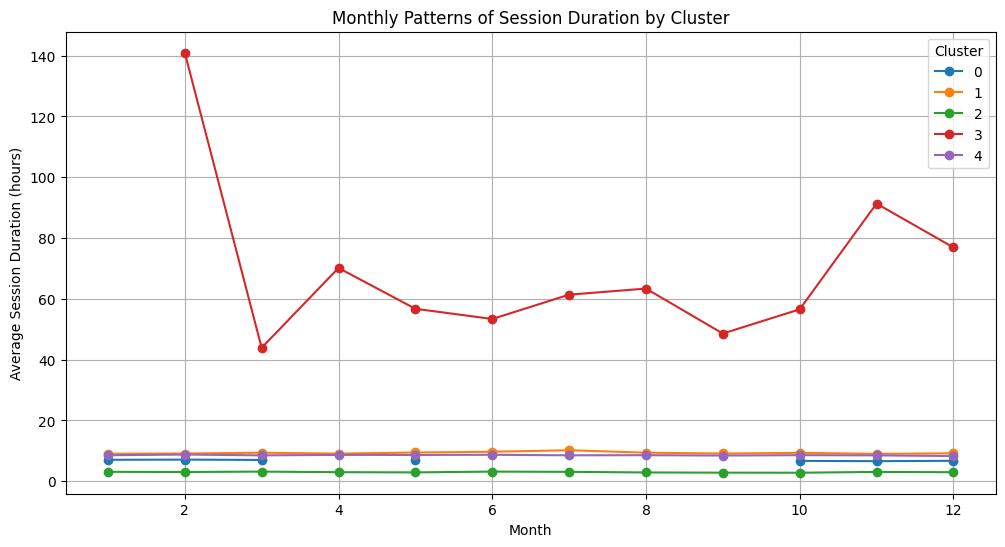

In [48]:
# Time series analysis for seasonal patterns
charging_sessions_data["month"] = charging_sessions_data["connectionTime"].dt.month
monthly_patterns = charging_sessions_data.groupby(["month", "cluster"])["session_duration"].mean().unstack()

monthly_patterns.plot(kind="line", figsize=(12, 6), marker="o")
plt.title("Monthly Patterns of Session Duration by Cluster")
plt.xlabel("Month")
plt.ylabel("Average Session Duration (hours)")
plt.grid()
plt.legend(title="Cluster")
plt.show()


Cluster 3 (red) shows significantly higher session durations, peaking in February (~140 hours) and fluctuating throughout the year. Clusters 0, 1, 2, and 4 remain relatively stable within a lower range (~3–10 hours). This discrepancy could be due to different usage patterns, specific station characteristics, or data anomalies such as outliers.

### Normalize data for meaningful comparison

<Figure size 1200x800 with 0 Axes>

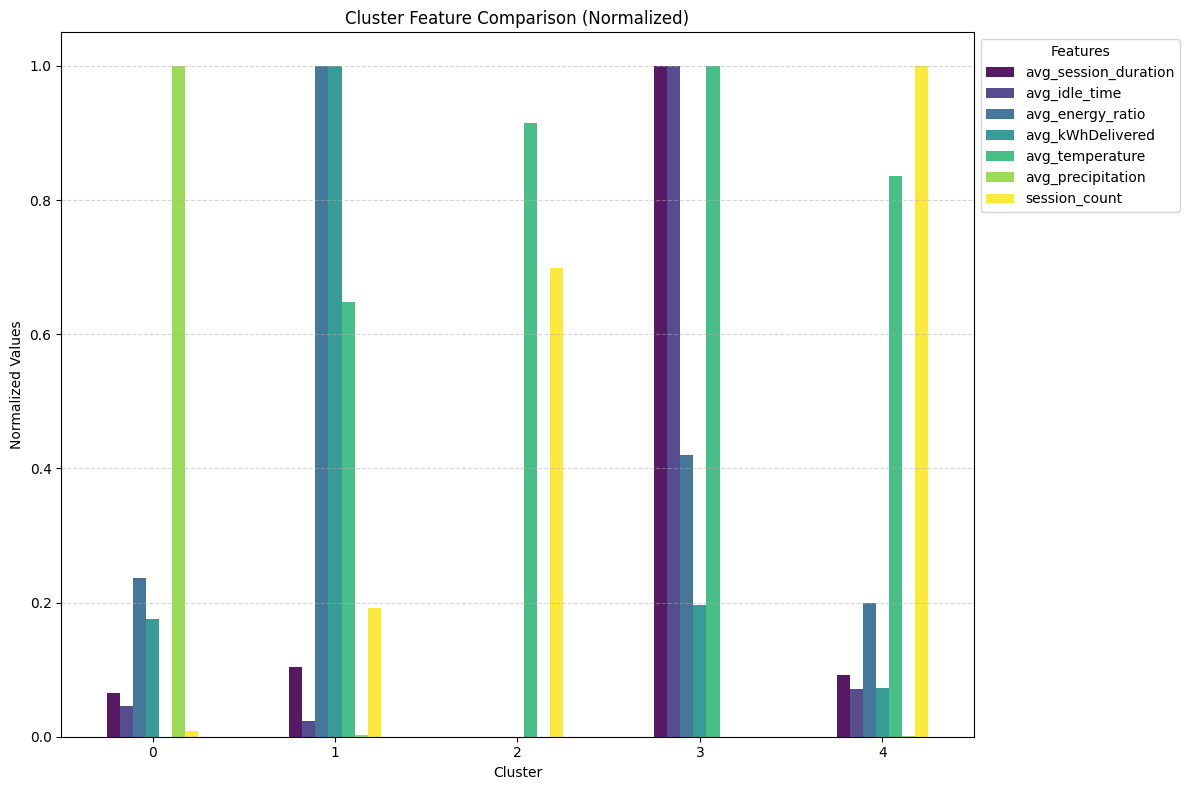

In [49]:
# Normalize data for meaningful comparison
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(cluster_summary)

# Convert to DataFrame for better handling
normalized_df = pd.DataFrame(
    normalized_data,
    columns=cluster_summary.columns,
    index=cluster_summary.index
)

# Plot the normalized data
plt.figure(figsize=(12, 8))
normalized_df.plot(kind="bar", figsize=(12, 8), colormap="viridis", alpha=0.9)
plt.title("Cluster Feature Comparison (Normalized)")
plt.xlabel("Cluster")
plt.ylabel("Normalized Values")
plt.xticks(rotation=0)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Features")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

This bar chart compares several normalized features across clusters, including session duration, idle time, kWh delivered, temperature, precipitation, and session count. Cluster 4 stands out with the highest kWh delivered, while Cluster 3 remains low across most session metrics. Cluster 0 shows the highest session count, whereas Cluster 1 has particularly high session duration and idle time. In terms of weather factors, Cluster 2 appears to have a lower average temperature, while Cluster 3 shows relatively higher values